# Python code

## Imports

In [1]:
import os
import sys
import cv2
import time
import serial
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import image as mpimg
import requests
from IPython.display import display, clear_output

# Adding the src folder in the current directory as it contains the script for Thymio and local occupancy
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio
robot = Thymio.serial(port='COM3', refreshing_rate=0.1)

#configure the webcam
url = "http://192.168.0.180:8080/shot.jpg"

## Global variable

In [44]:
##### VISION
MAP_SIZE = 50           # size of the grid
max_val = MAP_SIZE

# values used to crop the image given by the camera
X_SIZE = 1045
Y_SIZE = 1005
X_OFFSET = 640
Y_OFFSET = 95

USEABLE_THRESHOLD = 90
OBSTACLE_THRESHOLD = 90
MAX_VAL_RGB = 255

NB_EXP_TURN = 3
EMPTY = 0               # state of the squares of the grid 
OCCUPIED = 1
EXPANDED = 2            # We use those states to enlage the obstacle for the robot to be able to move along them
INCUBATION = 3


##### ODOMETRY
FOURCHETTE = 5         # in degrees

## DO NOT CHANGE
CALIBRATION_TIME_ANGLE = 9.6
CALIBRATION_ANGLE = 340
CALIBRATION_TIME = 3.47 # time needed to do the DISTANCE_CALIBRATION
DISTANCE_CALIBRATION = 10.7
COTE_CARRE_MAP = 150 / MAP_SIZE


##### AVOIDANCE
## DO NOT CHANGE
SENSOR_0 = 0
SENSOR_1 = 1
SENSOR_2 = 2
SENSOR_3 = 3
SENSOR_4 = 4
SENSOR_5 = 5
SENSOR_6 = 6
ALL_FRONT_SENSOR = 5
PARTIALY_ALL_FRONT_SENSOR = 4


PROXIMITY_THRESHOLD = 3800  # around 2cm
TIME_SLEEP_OBSTACLE = 0.1   # in seconds
DISTANCE_AVOIDANCE = 15     # to move away from the obstacle after avoiding it
OFFSET_TARGET = 8           # to change the target after meeting an obstacle unfortunate

#ALL
MOTOR_SPEED = 80
GET_TARGET = 3


### Calibration

In [45]:
#calibration
#t0=time.time()
#robot_turn(360, 'right',0)
#print(time.time()-t0)

### Global path

In [46]:
def create_empty_plot(max_val):
    """
    For plotting matters
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [47]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [48]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [49]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val=MAP_SIZE):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [50]:
def findroute(start, goal, occupancy_grid):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes

In [51]:
def plot_map(visitedNodes, path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return  fig_astar, ax_astar

In [52]:
def plot_step(path, start, goal, occupancy_grid, fig_astar, ax_astar):
    clear_output(wait = True)
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return

### Vision

get_image gets the image from the camera, crop it to the desired size and send it to the other function. It also checks if the camera is obstructed and return a boolean true if the camera is useable (i.e. not obstructed) and false otherwise.

In [53]:
def get_image():
    
    # get image from camera
    vid_frames = requests.get(url)
    img_array = np.array(bytearray(vid_frames.content), dtype = np.uint8)
    img = cv2.imdecode(img_array, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # crop the image to fit the desired grid
    img = img[Y_OFFSET:Y_OFFSET+Y_SIZE,X_OFFSET:X_OFFSET+X_SIZE]
    
    # plot the cropped image to check if the borders match what we want
    #plt.figure(figsize=(7,7))
    #plt.imshow(img)
    
    # check if the camera is hidden
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(grayImage.mean()<USEABLE_THRESHOLD):
        useable = False
    else:
        useable = True
    
    return img, useable

expand_grid modify the occupancy_grid by expanding the obtacles by the number of cell defined in NB_EXP_TURN so that the Thymio doesn't go too close to them. Each turn is composed of two phases : one expandation turn where every cell in contact with an obstacle becomes in the state INCUBATION, and one incubation turn where every cell in INCUBATION becomes an EXPANDED cell (equivalent to an obstacle we just use that to plot the difference between original and expended obstacles)

In [54]:
def expand_grid(occupancy_grid):
    
    # nb of cell we want to expand each obstacle
    nb_exp_turn = NB_EXP_TURN  
    
    # expand the obstacles grid by adding one obstacle cell at each turn
    for i in range(nb_exp_turn):
        occupancy_grid = expandation_turn(occupancy_grid)
        occupancy_grid = incubation_turn(occupancy_grid)
    
    return occupancy_grid

expandation_turn goes through the occupancy_grid and for each OCCUPIED or EXPANDED cell, we put all the surrounding cells in the INCUBATION state

In [55]:
def expandation_turn(occupancy_grid):
    
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==OCCUPIED or occupancy_grid[i,j]==EXPANDED):
                
                # just some notation (L_col is left column, T_line is top line...)
                # we check if the surrounding cells are in the grid
                if(j==0):
                    L_col = j
                else:
                    L_col = j-1

                if(i==0):
                    T_line = i
                else:
                    T_line = i-1

                if(j==MAP_SIZE-1):
                    R_col = j
                else:
                    R_col = j+1

                if(i==MAP_SIZE-1):
                    B_line = i
                else:
                    B_line = i+1
                
                # some notation again (BL is bottom left cell according to the current cell...)
                TL = [T_line, L_col]
                T = [T_line, j]
                TR = [T_line, R_col]
                ML = [i, L_col]
                MR = [i, R_col]
                BL = [B_line, L_col]
                B = [B_line, j]
                BR = [B_line, R_col]
                
                # contains all the cell to test (i.e. all the cells around the current cell)
                boxes_to_test = [TL, T, TR, ML, MR, BL, B, BR]
                
                for k in boxes_to_test:
                    if(occupancy_grid[k[0],k[1]]==EMPTY):
                        occupancy_grid[k[0],k[1]]=INCUBATION
                        
    return occupancy_grid

incubation_turn goes through the occupancy_grid and for each INCUBATION cell, we put it in the EXPANDED state

In [56]:
def incubation_turn(occupancy_grid):

    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==INCUBATION):
                occupancy_grid[i,j]=EXPANDED
                
    return occupancy_grid

get_occupancy_grid takes in input the cropped image and give in output the occupancy_grid with the expanded obstacles.

In [57]:
def get_occupancy_grid(img):

    # we put in image in grey scale and resize it according to the MAP_SIZE we want
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(grayImage, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
    
    # we do a threshold on the grayscale image to identify obstacles since they're black
    ret,thresh1 = cv2.threshold(resized,OBSTACLE_THRESHOLD,MAX_VAL_RGB,cv2.THRESH_BINARY_INV)
    occupancy_grid = thresh1.copy()
    occupancy_grid = occupancy_grid/MAX_VAL_RGB
    occupancy_grid = np.array(occupancy_grid, dtype=int)
    occupancy_grid = np.flip(occupancy_grid, 0)
    occupancy_grid = occupancy_grid.transpose()
    
    # we expand the obstacles
    occupancy_grid = expand_grid(occupancy_grid)

    occupancy_grid = np.array(occupancy_grid)
    
    return occupancy_grid

get_data takes in input the cropped image and use template matching to give the position and angle of the robot and the position of the goal

In [58]:
def get_data(img):
    
    original_height, original_width = img.shape[:2]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    ##################### GOAL ##########################
    
    template_goal = cv2.imread('goal_template_update.png')
    
    # code used to create the template to match
#     template_goal = img[780:862,100:190,:]
#     cv2.imwrite('goal_template.png', template_goal)
#     plt.figure()
#     plt.imshow(template_goal[:,:,::-1])
#     plt.show()

    # do the template matching and compute the position of the goal in the grid
    res = cv2.matchTemplate(img,template_goal,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    goal = min_loc
    x_goal=int(np.round(goal[0]*MAP_SIZE/original_width))
    y_goal=MAP_SIZE-int(np.round(goal[1]*MAP_SIZE/original_height))
    goal = (x_goal, y_goal)

    ##################### ROBOT ##########################
    
    template_back_point = cv2.imread('back_template - Copy.png')
    
    # code used to create the template to match
#     template_back_point = img[593:615,610:635,:]
#     cv2.imwrite('back_template.png', template_back_point)
#     plt.figure()
#     plt.imshow(template_back_point[:,:,::-1])
#     plt.show()

    # do the template matching and compute the position of the back point in the image
    res = cv2.matchTemplate(img,template_back_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    back = [min_loc[0], min_loc[1]]
    #print("Position of the back point [x, y] :", back)
    back[1] = original_height-back[1]


    template_front_point = cv2.imread('front_template - Copy.png')
    
    # code used to create the template to match
#     template_front_point = img[625:650,605:630,:]
#     cv2.imwrite('front_template.png', template_front_point)
#     plt.figure()
#     plt.imshow(template_front_point[:,:,::-1])
#     plt.show()

    # do the template matching and compute the position of the front point in the image
    res = cv2.matchTemplate(img,template_front_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    front = [min_loc[0], min_loc[1]]
    #print("Position of the front point [x, y] :", front)
    front[1] = original_height-front[1]

    ############ Compute pos and orientation ############

    # compute x and y position of the robot in the grid
    x=(back[0]+front[0])/2
    y=(back[1]+front[1])/2
    x=int(np.round(x*MAP_SIZE/original_width))
    y=int(np.round(y*MAP_SIZE/original_height))

    # vector representing the orientation of the robot
    v = [front[0]-back[0], front[1]-back[1]]
    
    # angle of the robot with respect to the x axis
    theta = math.atan2(v[1],v[0])

    robot_pose = [x, y, theta]
    start = (x,y)
    #print("Position of the robot [x, y, theta] :", robot_pose)
    
    return robot_pose, start, goal

### Odometry

In [59]:
def robot_turn(gamma, direction,alpha): #return alpha, direction, obstacle_seen (bool: 0->free)
    #This function makes the robot turn the desired angle
    #This is done by making it turn a calibrted time so given its speed, it's equivalent to the desired angle
    gamma = abs(gamma)
    time_turn = CALIBRATION_TIME_ANGLE*gamma/CALIBRATION_ANGLE
    obstacle_seen = 0
    
    if direction == "right":
        robot.set_var("motor.left.target", MOTOR_SPEED)
        robot.set_var("motor.right.target", int(int(2**16)-MOTOR_SPEED))
        t0 =time.time()
        while time.time()-t0 < time_turn :
            if (check_avoidance()) :
                obstacle_seen = 1
                avoid_obstacle()
                return alpha, direction, obstacle_seen
        
        alpha = angle_between_pi(alpha-math.radians(gamma))
        
    if direction == "left":
        robot.set_var("motor.left.target", int(int(2**16)-MOTOR_SPEED))
        robot.set_var("motor.right.target", MOTOR_SPEED)
        t0 =time.time()
        while time.time()-t0 < time_turn :
            if (check_avoidance()) :
                obstacle_seen = 1
                avoid_obstacle()
                return alpha, direction, obstacle_seen
        
        alpha = angle_between_pi(alpha+math.radians(gamma))
    
    direction = "forward"
    
    robot_stop()
    
    return alpha, direction, obstacle_seen

In [60]:
def angle_between_pi(angle): #return angle in [-pi,pi]
    if angle > math.pi :
        angle = angle - 2*math.pi
        return angle
    elif angle < -math.pi:
        angle = angle + 2*math.pi
        return angle
    else :
        return angle

In [61]:
def robot_move_forward(distance,xr,xt,yr,yt): # distance is in cm , returns new xr, yr, obstacle_seen (bool:0->free)
    
    obstacle_seen = 0
    time_forward = CALIBRATION_TIME*distance/DISTANCE_CALIBRATION
    
    #output values to the motor so the robot will move forward at the desired speed
    robot.set_var("motor.left.target", MOTOR_SPEED)
    robot.set_var("motor.right.target", MOTOR_SPEED)

    t0 =time.time()
    #Make sure the robot only moves forward for a time that given the speed set
    #will assure the robot moved of the desired distance
    while time.time()-t0 < time_forward :
        if (check_avoidance()) : #While the robot is moving forward check for obstacles
            obstacle_seen = 1
            avoid_obstacle()     #If an obstacle is seen, avoid it
            return xr, yr, obstacle_seen
    
    #update robot's position assuming he properly reached the target
    xr=xt 
    yr=yt
    
    #Stop the robot
    robot_stop()
    return xr, yr, obstacle_seen

In [62]:
def robot_stop() :
    #Stop the robot when needed
    
    robot.set_var("motor.left.target", 0)
    robot.set_var("motor.right.target", 0)
    return

In [63]:
def robot_evaluation (xr,xt,yr,yt, alpha): #return gamma in degrees, direction, distance in cm
    #This function is based on cases separation and gives a predefined output given the situation
    
    alpha = math.degrees(alpha)
    xr=xr*COTE_CARRE_MAP
    xt=xt*COTE_CARRE_MAP
    yr=yr*COTE_CARRE_MAP
    yt=yt*COTE_CARRE_MAP
    
    if yt>yr and xt<xr :
        gamma = math.degrees(math.atan2(yt-yr,xr-xt))

        if alpha<=0 :
            gamma = gamma + 180+alpha

            if gamma < 180 :
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma - alpha

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt<xr :  
        gamma = math.degrees(math.atan2(yr-yt,xr-xt))

        if alpha>=0 :
            gamma = gamma +180-alpha

            if gamma < 180 :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma + alpha

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt>xr :  
        gamma = math.degrees(math.atan2(yr-yt,xt-xr))

        if alpha>=0 :
            gamma = gamma + alpha

            if gamma > 180 :
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = -alpha - gamma

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        

    if yt>yr and xt>xr :
        gamma = math.degrees(math.atan2(yt-yr,xt-xr))

        if alpha<=0 :
            gamma = gamma - alpha

            if gamma > 180 :
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = alpha - gamma

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
    
    
    if yt==yr and xt>xr :
        gamma = 0
        distance = xt-xr
        
        if abs(alpha)< FOURCHETTE :
            
            #robot move forward
            return abs(gamma), "forward", distance
        elif alpha < -(FOURCHETTE/2) :
            #robot turn left
            return abs(alpha), "left", distance
        else :
            #robot turn right
            return abs(alpha), "right", distance
            
    if yt==yr and xt<xr :
        gamma = 180
        distance = xr-xt

        if alpha < 0 :
            gamma = gamma + alpha
            #robot turn right
            return abs(gamma), "right", distance
        else:
            gamma = gamma - alpha
            #robot turn left
            return abs(gamma), "left", distance
            
    
    if yt<yr and xt==xr :
        gamma = 90                           #=-90
        gamma = gamma+alpha
        distance = yr-yt

        if gamma < 0:
            #robot turn left
            return abs(gamma), "left", distance
        elif gamma > 180 :
            #robot turn left
            gamma= 360-gamma
            return abs(gamma), "left", distance
        else:
            #robot turn right
            return abs(gamma), "right", distance
            
            
    if yt>yr and xt==xr :
        gamma = 90
        gamma = gamma-alpha
        distance = yt-yr

        if gamma < 0 :
            #robot turn right
            return abs(gamma), "right", distance
        elif gamma > 180 :
            #robot turn right
            gamma= 360-gamma
            return abs(gamma), "right", distance
        else:
            #robot turn left
            return abs(gamma), "left", distance

In [64]:
def target_not_reach(xr,yr, target_list, id_target): # return bool yes/no
    #get target's position
    xt = target_list[0][id_target]
    yt = target_list[1][id_target]
    
    #then compare it to the robot's position
    if yt==yr and xt==xr :
        return False
    else:
        return True

## Motion control

In [65]:
def obstacle_avoidance(obstacle_direction,sensor_measurment):
    #This function gives appropriate values to the motors so the robot will avoid the detected obstacles
    #The values are based on which sensors atre reporting the detection of an obstacle
    
    if(np.shape(obstacle_direction)[0] == ALL_FRONT_SENSOR)or(np.shape(obstacle_direction)[0] == PARTIALY_ALL_FRONT_SENSOR):
        if(sensor_measurment[SENSOR_1]>sensor_measurment[SENSOR_3]):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        else:
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    else:
        if (np.any(np.equal(obstacle_direction,SENSOR_0)))or(np.any(np.equal(obstacle_direction,SENSOR_1))):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_3)))or(np.any(np.equal(obstacle_direction,SENSOR_4))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_2))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    return

In [66]:
def check_avoidance() :
    #Check if there are obstacles to avoid
    sensor_measurment = robot["prox.horizontal"]
    if np.all(np.less(sensor_measurment, PROXIMITY_THRESHOLD)):
        return 0
    else:
        return 1

In [67]:
def avoid_obstacle () :
    sensor_measurment = robot["prox.horizontal"]#get values from the sensors
    obstacle_direction = np.nonzero(sensor_measurment)[0]#find potential obstacles
    
    #While there are obstacles detected by the sensors:
    while((np.any(np.greater(sensor_measurment, PROXIMITY_THRESHOLD)))and(np.all(np.not_equal(obstacle_direction, SENSOR_5)))and(np.all(np.not_equal(obstacle_direction, SENSOR_6)))):
        #avoid obstacles
        obstacle_avoidance(obstacle_direction,sensor_measurment)
        time.sleep(TIME_SLEEP_OBSTACLE)

        #Update sensor measurments
        sensor_measurment = robot["prox.horizontal"]
        obstacle_direction = np.nonzero(sensor_measurment)[0]
    
    #Move forward a certain distance so the robot gets away from the obstacle
    robot_move_forward(DISTANCE_AVOIDANCE,0,0,0,0)
    
    robot_stop()
    return

In [68]:
def go_to_goal(target_list,occupancy_grid, fig_astar, ax_astar):
    #initialisation :
    img, useable = get_image()
    if(useable):
        (robot_pos, start, goal) = get_data(img)
        alpha = robot_pos[2] # in radian
    offset = 0
    id_target = 1

    #While we are not aiming at the last point of the route :
    while (id_target) < (len(target_list[0])) :
        #We check if the goal has moved
        if((goal[0] != target_list[0][len(target_list[0])-1]) or (goal[1] != target_list[1][len(target_list[1])-1])):
            return False #Return false if the goal moved so the main will recompute the global route
            
        #Update position using camera informations
        if(not (id_target%GET_TARGET)):
            img, useable = get_image()
            if(useable):
                (robot_pos, start, goal) = get_data(img)
                alpha = robot_pos[2] # in radian
            
        
        
        #If the current point we're aiming at is not reached :
        while (target_not_reach(robot_pos[0],robot_pos[1],target_list, id_target)):
            
            #we calculate how and how much it should move
            gamma, direction, distance = robot_evaluation (robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target], alpha)
            
            #then turns toward target
            alpha, direction, obstacle_seen = robot_turn(gamma, direction, alpha)
            
            #if he saw an obstacle while turning and avoided it
            if(obstacle_seen):
                #then we update position with camera
                img, useable = get_image()
                if(useable):
                    (robot_pos, start, goal) = get_data(img)
                    alpha = robot_pos[2] # in radian
                #we reinitialize obstacle_position
                obstacle_seen = 0
                #we say we want to skip the next few(OFFSET_TARGET) points in the route that are probably obstructed by an obstacle
                offset = OFFSET_TARGET
                direction = "right"
            
            #finally , once we are aligned, it goes towards target
            if direction == "forward":
                robot_pos[0], robot_pos[1], obstacle_seen = robot_move_forward(distance,robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target])
                #if he saw an obstacle while turning and avoided it
                if(obstacle_seen):
                    #then we update position with camera
                    img, useable = get_image()
                    if(useable):
                        (robot_pos, start, goal) = get_data(img)
                        alpha = robot_pos[2] # in radian
                    #we say we want to skip the next few(OFFSET_TARGET) points in the route that are probably obstructed by an obstacle
                    offset = OFFSET_TARGET
                    #we reinitialize obstacle_position
                    obstacle_seen =0
            
            #Actually skip the next few(OFFSET_TARGET) points in the route that are probably obstructed by an obstacle
            if id_target+offset < len(target_list[0])-1 :
                id_target = id_target + offset
                offset = 0
            else :
                id_target = len(target_list[0])-1
        
        #When the target is reached we increment id_target by 1 to aim at the next point in the route
        id_target = id_target + 1
        
        #and finally we plot the position of the robot along the path
        start=(robot_pos[0],robot_pos[1])       
        plot_step(path, start, goal, occupancy_grid,  fig_astar, ax_astar)
    
    #When the final goal is rached, we stop the robot
    robot_stop()
    return True
    

### Main function

(41, 11) (18, 27)


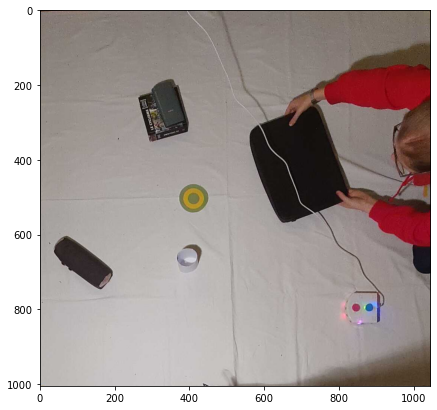

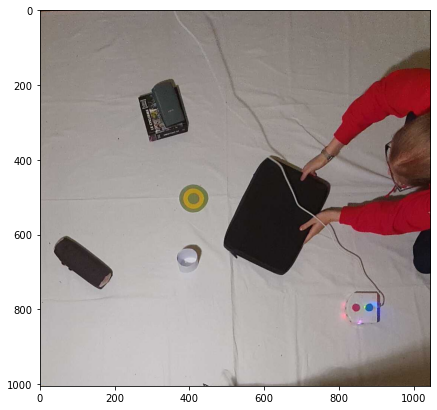

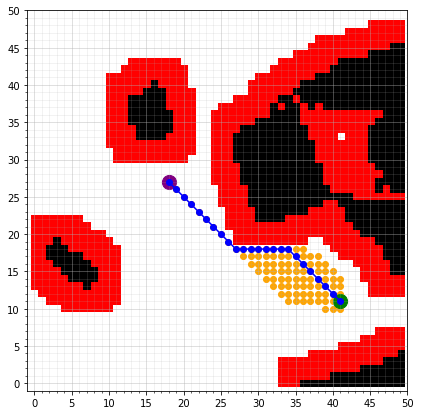

first 1
heeeeeeeey 1
second 2


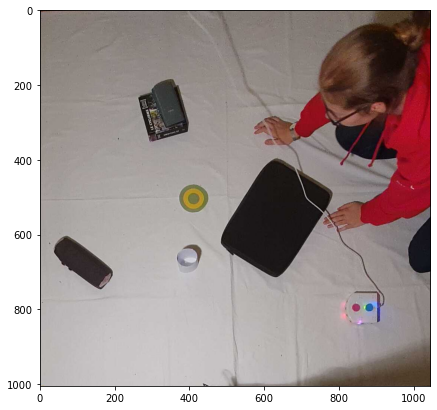

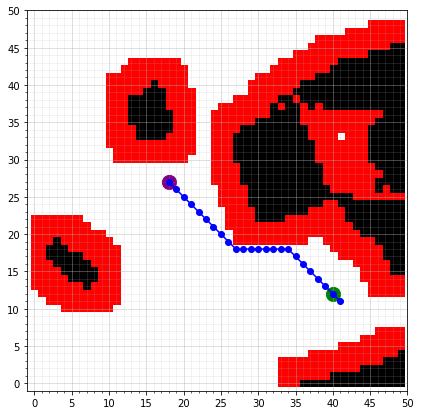

first 2
heeeeeeeey 2
second 3


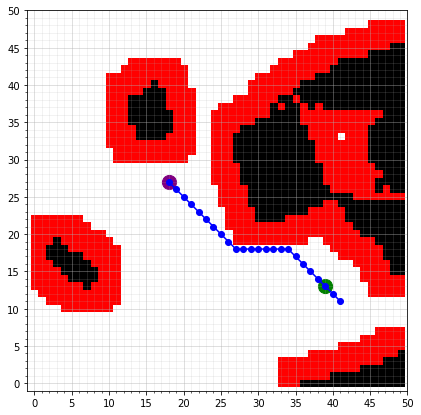

first 3
heeeeeeeey 3
second 4


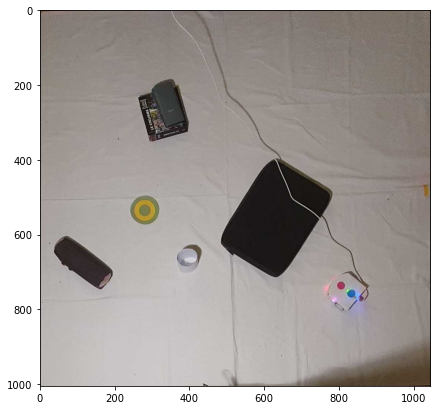

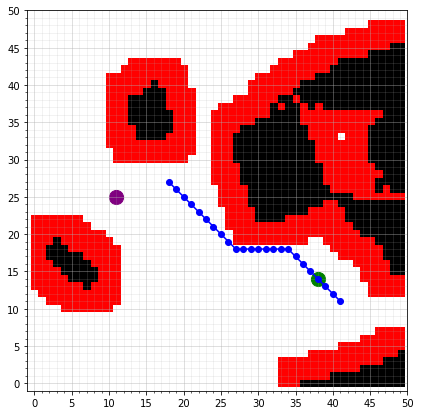

(38, 14) (11, 25)


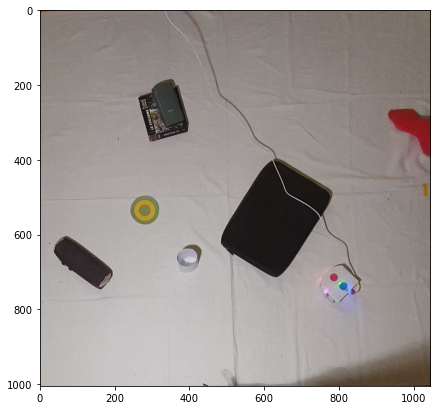

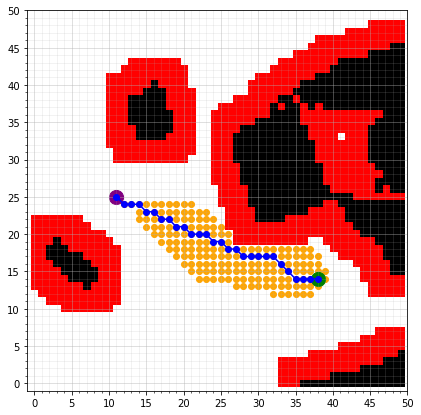

first 1
heeeeeeeey 1
second 2


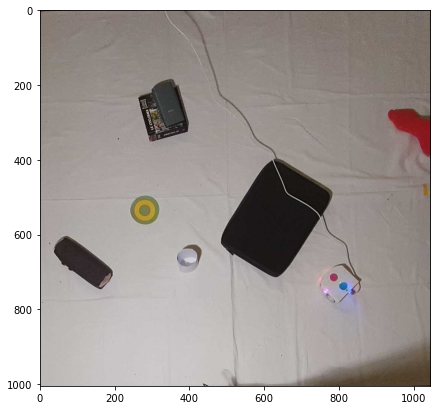

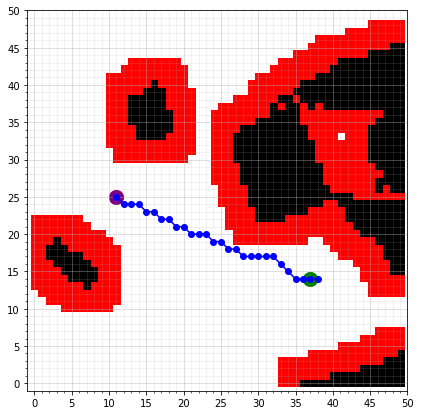

first 2
heeeeeeeey 2
second 3


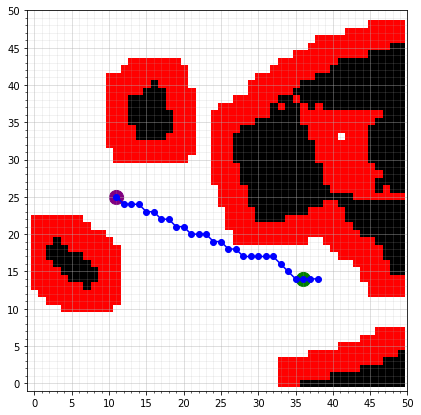

second 4


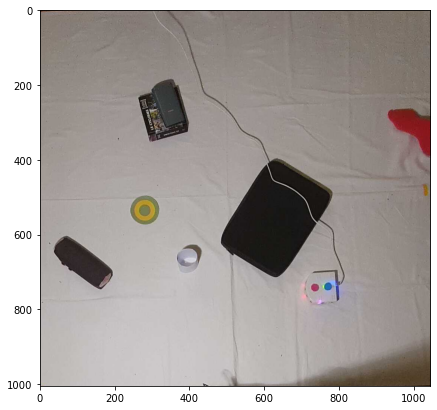

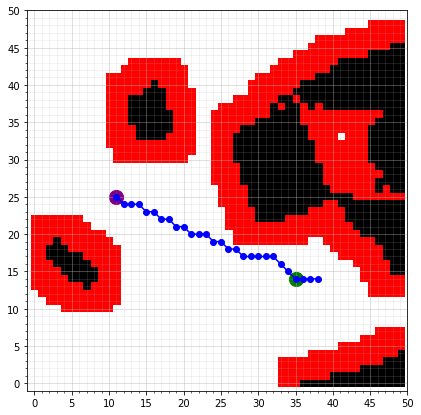

first 4
heeeeeeeey 4
second 5


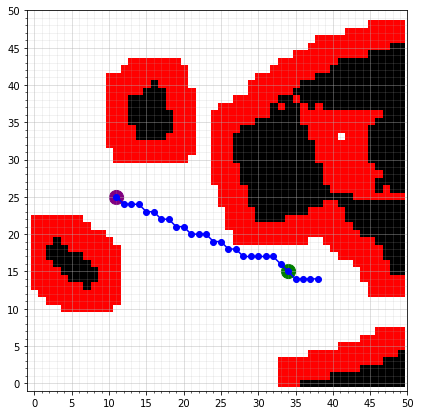

first 5
heeeeeeeey 5
second 6


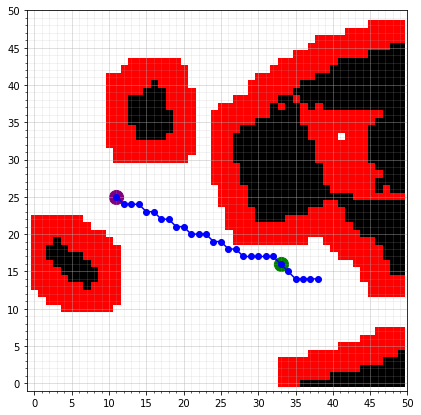

first 6
heeeeeeeey 6
second 7


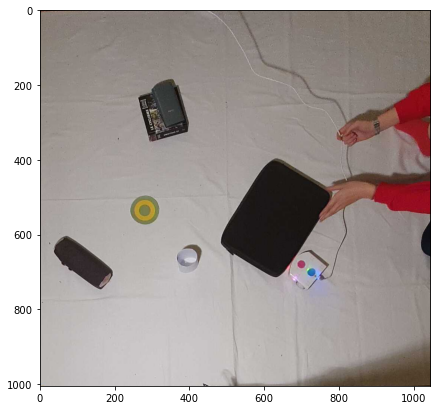

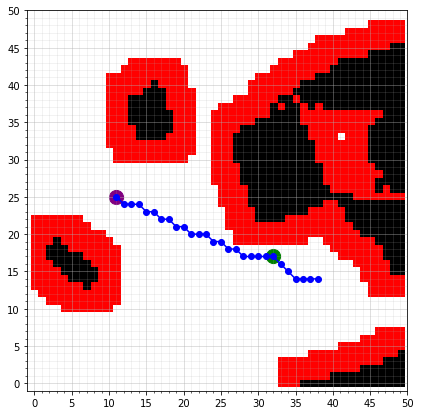

first 7
heeeeeeeey 7
second 8


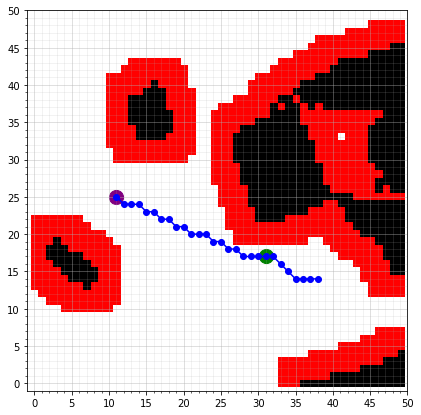

first 8
heeeeeeeey 8
second 9


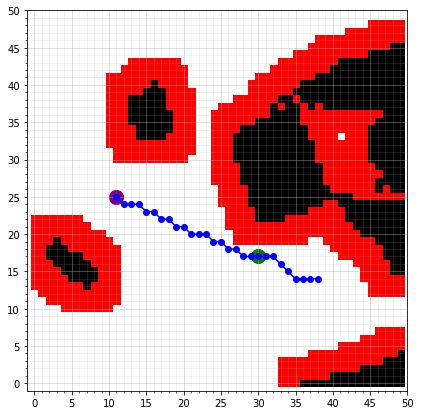

first 9
heeeeeeeey 9
second 10


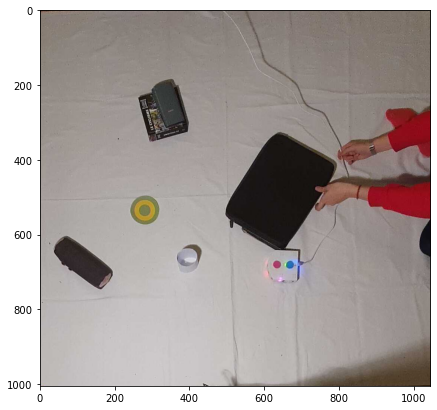

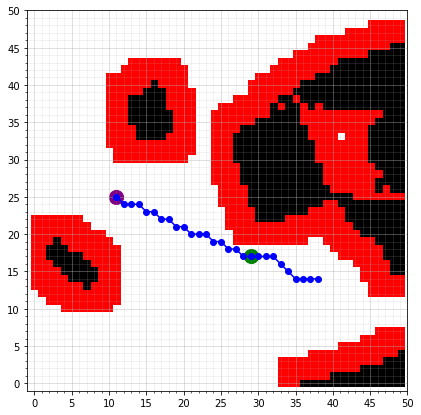

first 10
heeeeeeeey 10
second 11


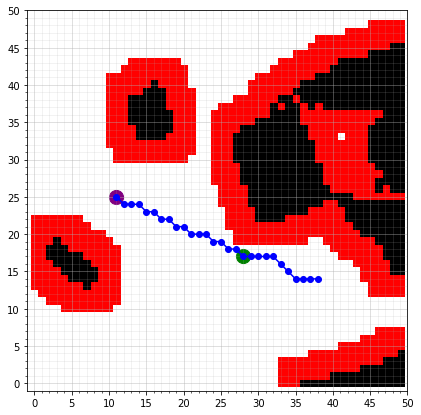

first 11
heeeeeeeey 11
second 12


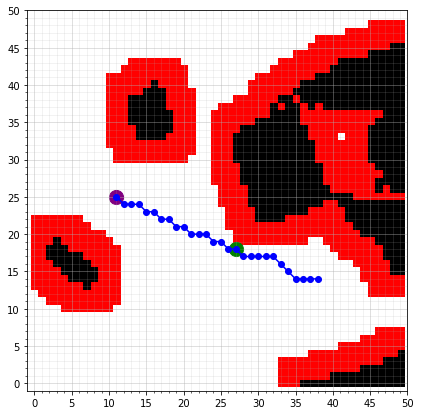

first 12
heeeeeeeey 12
second 13


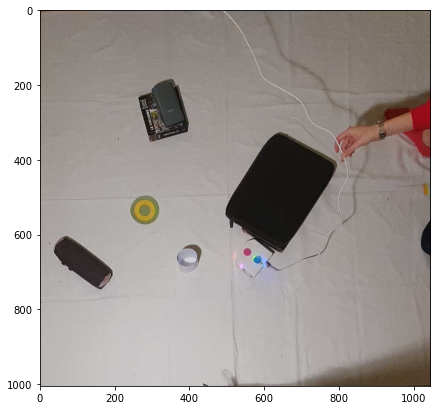

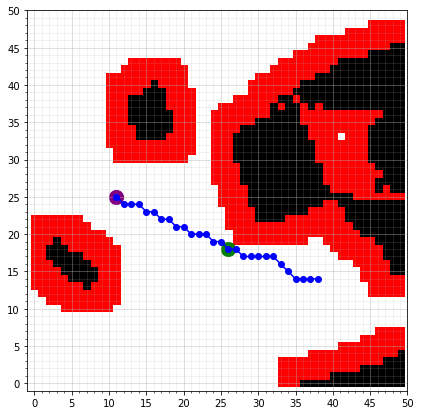

first 13
heeeeeeeey 13
second 14


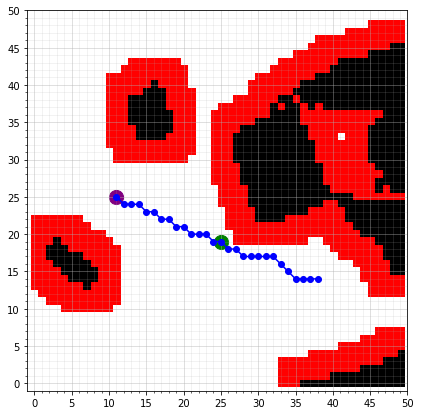

first 14
heeeeeeeey 14
second 15


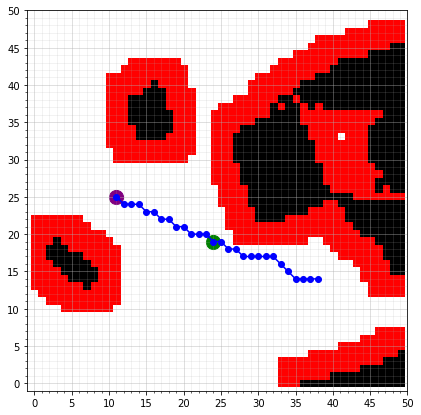

first 15
heeeeeeeey 15
second 16


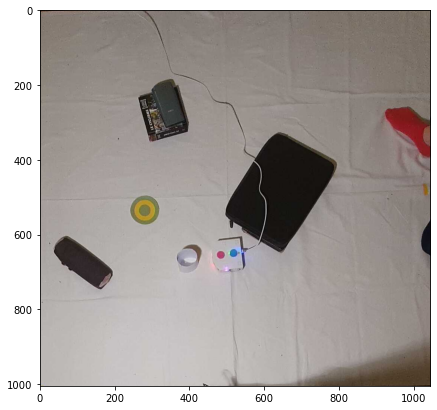

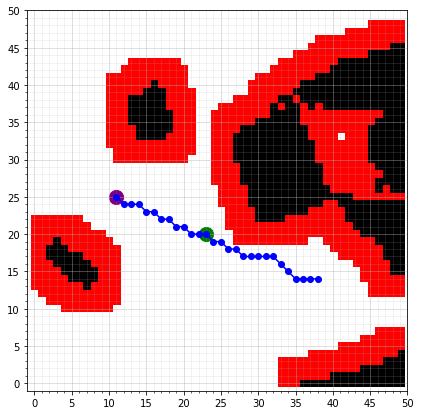

obstacle1
first 16
heeeeeeeey 24
first 24
heeeeeeeey 24
second 25


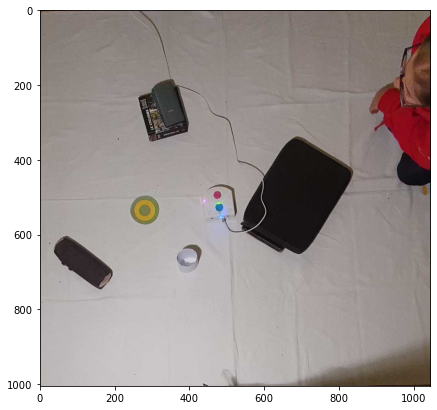

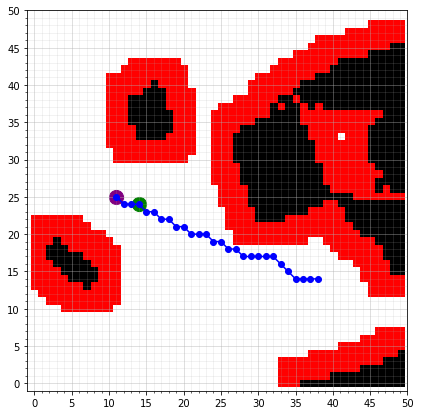

first 25
heeeeeeeey 25
second 26


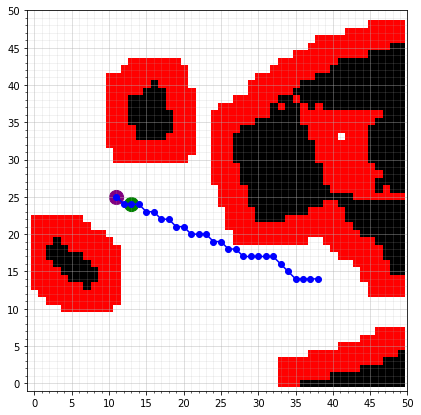

first 26
heeeeeeeey 26
second 27


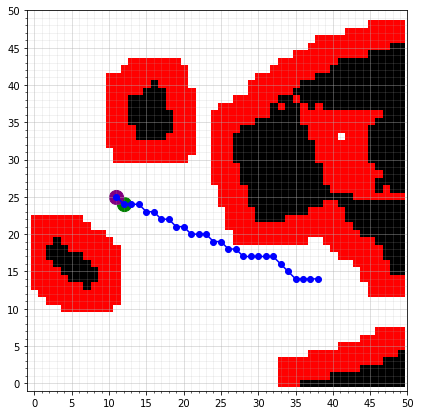

first 27
second 28


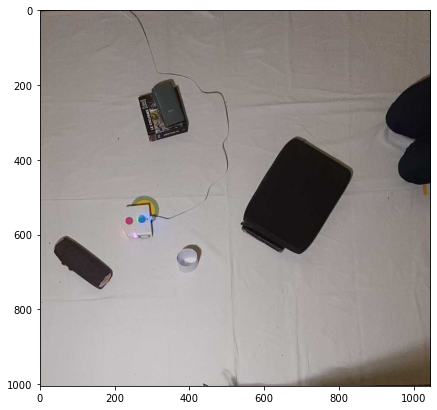

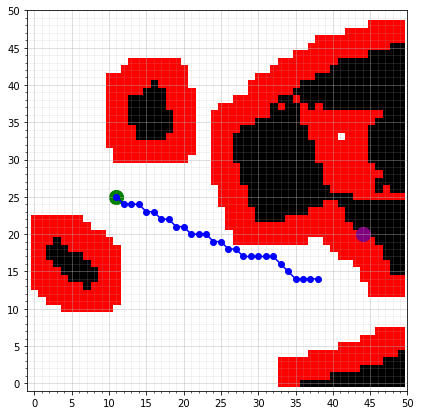

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\site-packages\serial\serialwin32.py", line 323, in write
    raise writeTimeoutError
serial.serialutil.SerialTimeoutException: Write timeout


In [307]:
# Main:
# Get a picture of the map 
img, useable = get_image()
if(not(useable)):
    raise Exception('Camera is obstructed')

# Get obstacle's postions
occupancy_grid = get_occupancy_grid(img)

success = False

#While target is not reached
while(not(success)):
    # Get robot and goal's positions
    time.sleep(2)
    img, useable = get_image()
    #Check if image is useable
    if(not(useable)):
        raise Exception('Camera is obstructed')
    (robot_pos, start, goal) = get_data(img)
    # Find a route
    path, visitedNodes = findroute(start, goal, occupancy_grid)
    # Plot everything
    (fig_astar, ax_astar) = plot_map(visitedNodes, path, start, goal, occupancy_grid)
    #try to go to goal
    success = go_to_goal(path, occupancy_grid,  fig_astar, ax_astar)